<a href="https://colab.research.google.com/github/Pengwei-Yang/NLP/blob/main/Multimodal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Initial Setup

## Libraries

In [ ]:
import os
import re
import csv
import string
import pandas as pd
import numpy as np
import statistics
import itertools
from PIL import Image
import time
from io import StringIO
from skimage import io
import matplotlib.pyplot as plt
import torch
from torch import nn
import torchvision
from torchvision import models
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.transforms import ToTensor, Lambda, Resize, Compose, ToPILImage, Normalize, RandomCrop, RandomHorizontalFlip, RandomVerticalFlip
import matplotlib.pyplot as plt
import csv
from sklearn.metrics import f1_score, confusion_matrix, precision_score, recall_score

## Drive/file/device setup

In [ ]:
#Set up google drive directory
from google.colab import drive
drive.mount('/content/drive')


# #ZIP_PATH = #Comment path here

# ZIP_FILENAME = '2021s1comp5329assignment2.zip'

# !cp '{ZIP_PATH}' .
# !unzip -q '{ZIP_FILENAME}'
# !rm '{ZIP_FILENAME}'

Mounted at /content/drive


In [ ]:
DIR = '/content/drive/MyDrive/COMP5329_Deep_Learning_Shared/Assignment_2/COMP5329S1A2Dataset'

TRAIN_CSV = os.path.join(DIR, "train.csv")
TEST_CSV = os.path.join(DIR, "test.csv")
IMAGES_DIR = os.path.join(DIR, "data")

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')

Using cuda device


# Data Read

## AssignmentDataset Class

In [ ]:
class AssignmentDataset(Dataset):
    '''
    The AssignmentDataset Class, child of torch.utils.data.Dataset.

    Attributes:
    csv_file (str): A string representation of the file directory to the csv data file.
    image_dir (str): A string representation of the file directory to the images data file.
    transform (torchvision.transforms.Compose): A torchvision.transforms.Compose object consisting of desired transforms to be made to the image data.
    target_transform (function): A function to be passed to the label data for any desired transformations. Used to apply one-hot encoding.
    has_labels (Bool): A boolean value to flag whether the dataset has labels or not, i.e. if it is training or testing.
    '''

    def __init__(self, csv_file, image_dir, transform=None, target_transform=None, has_labels = True):
        self.image_dir = image_dir
        self.transform = transform
        self.target_transform = target_transform
        self.has_labels = has_labels

        with open(csv_file) as file:
            lines = [re.sub(r'([^,])"(\s*[^\n])', r'\1/"\2', line) for line in file]
            self.dataframe = pd.read_csv(StringIO(''.join(lines)), escapechar="/")


    def __len__(self): # 这个在对实例化类对象使用len()的时候自动调用
        '''
        Returns the length of the dataframe representation of the csv component of the dataset.

        Parameters:
        None

        Returns:
        self.dataframe.shape[0] (int): The length of the datasets dataframe representation.

        '''
        return self.dataframe.shape[0]

    def __getitem__(self, idx): # 只要调用类AssingmentDataset的实例化对象并传入索引时，该部分激活。例如实例化为dataset时，for i in dataset
        '''
        Reads the data from the dataframe then outputs the observation's image tensor, OHE label tensor (if there are labels present), ImageID string and caption string in a tuple form.

        Parameters:
        idx (int): The index for which observation to return.

        Returns:
        sample (tuple): The tuple containing the observation's image tensor, OHE label tensor (if present), ImageID string and caption string.
        '''

        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_path = os.path.join(self.image_dir,
                                self.dataframe.iloc[idx, self.dataframe.columns.get_loc('ImageID')])

        img = io.imread(img_path)

        img_id = self.dataframe.iloc[idx, self.dataframe.columns.get_loc('ImageID')]
        caption = self.dataframe.iloc[idx, self.dataframe.columns.get_loc('Caption')]

        if self.has_labels:
          labels = self.dataframe.iloc[idx, self.dataframe.columns.get_loc('Labels')] #
          labels = labels.split(' ') # converts the string into an iterable Python list
          labels = [int(x) for x in labels] # convert the string of numbers into integer using Pytorch for computation speed 将labels转化为一个列表

          if self.target_transform:
              labels = self.target_transform(labels)  # 把对应的label转换成one-hot encodding
          if self.transform:
              img = self.transform(img) # 转变图像的size等

          sample = (img, labels, img_id, caption) # 整合为图像，对应的一系列标签，图像id 以及 图像对应的描述

        else:
          if self.transform:
              img = self.transform(img)
          sample = (img, img_id, caption) #这个是test data 没有标签的情况

        return sample # 在调用这个类的实例化的时候，返回的其实是由以上几个元素组成的元组

## Finding mean/standard deviation for normalization

Define image_stats function to return means and standard deviations per channel in a dataloader.

## image_stats function

In [ ]:
def image_stats(checking_dataloader):
  '''
  A function to calculate the channel means and standard deviations of the image input in a training dataset.
  Sums the channel means & squared means per image, then calculates the overall mean and standard deviation by taking the first moment (mean) and square root of the second moment (variance).

  Parameters:
  checking_dataloader (torch.utils.data.Dataloader): The Dataloader object with a batch size of 1 and containing images, image labels, image IDs and captions.

  Returns:
    means (torch.Tensor): A tensor object containing the channel means as floats.
    stdevs (torch.Tensor): A tensor object containing the channel standard deviations as floats.
  '''

  sum_channels, sumsq_channels, n_batches = 0, 0, 0

  for step, (x, _, _, _ ) in enumerate(checking_dataloader):
    sum_channels += torch.mean(x, dim = [0, 2, 3])
    sumsq_channels += torch.mean(x**2 , dim = [0, 2, 3])
    n_batches += 1

  means = sum_channels/n_batches
  stdevs = (sumsq_channels/n_batches - means**2)**0.5

  return means, stdevs

##Checking dataset/loader

<br> Set up a "checking" dataset of the data to use in the image_stats function - note the batch size of 1.

In [ ]:
##Finding Mean/std
NUM_LABELS = 19
BATCH_SIZE = 1

transforms = Compose([
    ToTensor(),
])

train_dataset_check = AssignmentDataset(csv_file = TRAIN_CSV,
                                 image_dir = IMAGES_DIR,
                                 transform = transforms,
                                 target_transform = Lambda(lambda y: torch.zeros(NUM_LABELS, dtype=torch.uint8).scatter_(dim=0, index=torch.sub(torch.tensor(y), 1), value=1)),
                                  has_labels = True,
                                 )

In [ ]:
train_dataloader_check = DataLoader(train_dataset_check, batch_size=BATCH_SIZE, shuffle=False)

## Calculate & print mean/standard deviation

In [ ]:
means, stdevs = image_stats(train_dataloader_check)
print(f'Mean is: {means} \n Standard Deviation is: {stdevs}')

KeyboardInterrupt: ignored

## Sanity check image sizes - create get_image_size function

In [ ]:
def get_image_sizes(checking_dataloader):
    '''
    Obtains the heights and widths of the images within the supplied dataset.

    Parameters:
    checking_dataloader (torch.utils.data.Dataloader): The Dataloader object with a batch size of 1 and containing images, image labels, image IDs and captions.

    Returns:
      heights (list(int)): A list of the image heights as integers.
      widths (list(int)): A list of the image widths as integers.
    '''

    heights, widths = [], []

    for step, (img, _, _, _) in enumerate(checking_dataloader):
        heights.append(img.size()[2])
        widths.append(img.size()[3])

    return heights, widths

In [ ]:
heights, widths = get_image_sizes(train_dataloader_check)

print(f'Median height is: {statistics.median(heights)}')
print(f'Mean height is: {statistics.mean(heights)}')
print(f'Median width is: {statistics.median(widths)}')
print(f'Mean width is: {statistics.mean(widths)}')

## Creating Train/Test/Validation Datasets and Dataloaders

In [ ]:
# Concluded 19 labels - one-hot encoded. Leaving label 12 in there as it'll just have zeros for this index
NUM_LABELS = 19
BATCH_SIZE = 32
CROP_SIZE = 224 # Seems to be the standard image size used (224)
TRAIN_VAL_PROP = 0.75
SEED = 42

transforms = Compose([
    ToTensor(),
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    Resize((224, 224)),
    RandomHorizontalFlip(),
    RandomVerticalFlip(),
    RandomCrop(CROP_SIZE)
])

# The main dataset available with labels
main_dataset = AssignmentDataset(csv_file = TRAIN_CSV,
                                 image_dir = IMAGES_DIR,
                                 transform = transforms,
                                 target_transform = Lambda(lambda y: torch.zeros(NUM_LABELS, dtype=torch.uint8).scatter_(dim=0, index=torch.sub(torch.tensor(y), 1), value=1)),
                                 has_labels = True
                                 )

# Need to further split it up
train_dataset, val_dataset = random_split(main_dataset,
                                          [int(round(TRAIN_VAL_PROP * len(main_dataset))), int(round((1 - TRAIN_VAL_PROP) * len(main_dataset)))],
                                          generator=torch.Generator().manual_seed(SEED)) # Setting seed to ensure consistency

# The final test dataset with no labels
test_dataset = AssignmentDataset(csv_file = TEST_CSV,
                                 image_dir = IMAGES_DIR,
                                transform = transforms,
                                 has_labels = False)

main_dataloader = DataLoader(main_dataset, batch_size = BATCH_SIZE, shuffle=True)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Miscellaneous Functions

## Encoding/Decoding label functions

In [ ]:
def encode_outputs(output, threshold):
  '''
  A function to transform sigmoid outputs to one-hot encoded representations, based on a threshold value which deems the sigmoid output to be positive.
  Creates a numpy array filled with zeros per observation, transforms this to a list and appends an index with 1s if the sigmoid output of the index is greater than the threshold then appends this observation to the encoded_outputs list containing all observations.

  Parameters:
  output (torch.Tensor): A torch tensor of model output/predictions, calculated on a dataset with a batch size of 1.
  threshold (float): The desired probability threshold to consider a sigmoid output as a positive classification.

  Returns:
  encoded_outputs (list(list(int))): A list per observation containing a list of one-hot encoded predictions as integers with length 19.
  '''

  encoded_outputs = []
  for i in range(len(output)):
    encoded_output = np.zeros(19).tolist()
    for j in range(len(output[i][0])):
      encoded_output[j] = 1 if output[i][0][j].item() >= threshold else 0
    encoded_outputs.append(encoded_output)
  return encoded_outputs

def decode_labels(labels, threshold):
  '''
  A function to transform sigmoid outputs or OHE predictions to a list of numeric labels.
  Creates an empty list for an individual observation, appends with the value of the index + 1 which has the prediction greater than the threshold and aggregates in the decoded_labels list for all observations.

  Parameters:
  labels (list(torch.Tensor)): A list per observation of the one-hot encoded labels in a torch.Tensor.
  threshold (float): The desired probability threshold to consider a sigmoid output as a positive classification.

  Returns:
  decoded_labels (list(list(str))): A list for each observation containing a list of the labels as strings.
  '''

  decoded_labels = []
  for i in range(len(labels)):
    decoded_label = []
    for j in range(len(labels[i][0])):
      if labels[i][0][j].item() >= threshold:
        decoded_label.append(j + 1)
    decoded_labels.append(decoded_label)
  return decoded_labels

## Plots

show img function

In [ ]:
def show_img(dataset):
  '''
  A function to show a 2 x 3 plot of 6 random images and display the one-hot encoded labels above it.

  Parameters:
  dataset (AssignmentDataset): The dataset containing the desired set of images for which samples are to be plotted.

  Returns:
  None
  '''

  loader = DataLoader(train_dataset, batch_size = 6, shuffle = True)
  batch = next(iter(loader))
  images, labels,_,_ = batch

  grid = torchvision.utils.make_grid(images, nrow = 3)
  plt.figure(figsize = (12, 12))
  plt.imshow(np.transpose(grid, (1,2,0)))

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


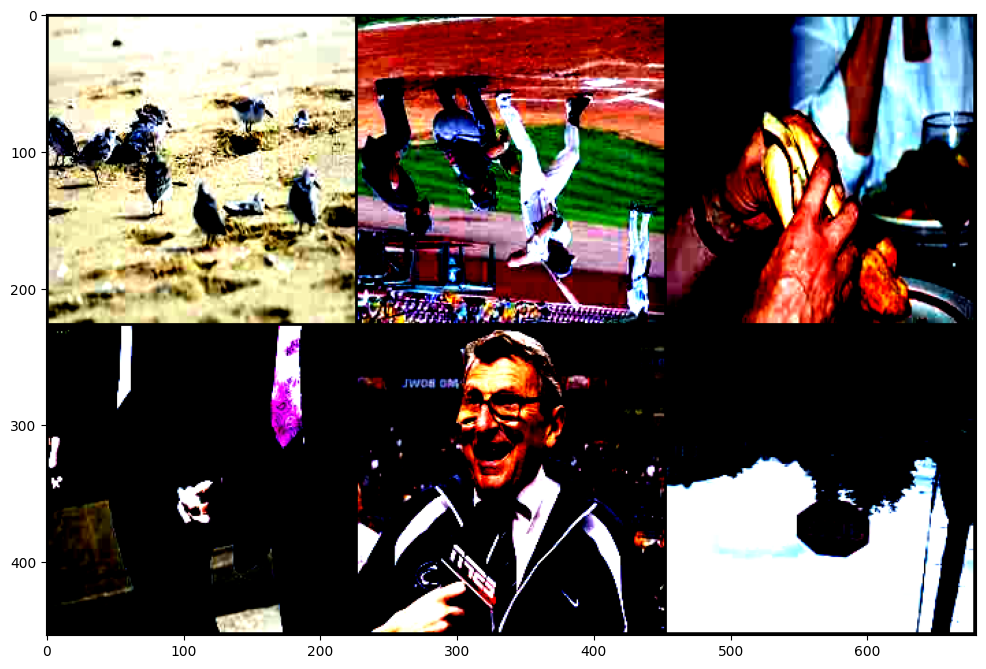

In [ ]:
show_img(train_dataloader)

## Training Setup

### Training loop funciton

In [ ]:
def train_loop(dataloader, val_dataloader, model, loss_fn, optimizer, test_threshold=None, with_captions=False):
    '''
    The function to run a training loop on a selected model and returns training losses per batch as well as validation loss & validation f1 if applicable.

    Sets the model to train model, iterates through the dataloader and passes the data forward through the network then calculates loss. Removes accumulated gradients in the optimizer and runs the backpropagation process, finally updating the parameters.
    Prints training updates as well as validation scores based on the test_threshold value.

    Parameters:
    dataloader (torch.utils.data.Dataloader): The dataloader object for the training data.
    val_dataloader(torch.utils.data.Dataloader): The dataloader object for the validation data.
    Model (child of torch.nn.Module): The chosen Model to train.
    loss_fn: The chosen loss function for learning & evaluation.
    optimizer: The chosen optimizer for parameter updates.
    test_threshold (float or None): The threshold on which to convert sigmoid outputs to positive labels in validation, or None to ensure validation is not conducted in training. Set to None by default.
    with_captions (bool): The boolean value indicating whether image captions are to incorporated into the model.

    Returns:
      train_batch_losses (list): A list of the loss values per training batch.
      val_batch_losses (list): A list of the loss values per validation epoch.
      val_f1_scores (list): A list of the mean F1 scores per validation epoch.
    '''

    train_batch_losses = []
    val_batch_losses = []
    val_f1_scores = []

    size = len(dataloader.dataset)
    # Set the model to training mode
    model.train()

    for batch, (X, y, _, captions) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        if with_captions:
            # Perform encoding for the captions
            word_encoding_array = encode_captions(captions)
            # Compute prediction and loss
            pred = model(X, word_encoding_array)
        else:
            pred = model(X)

        if type(model) == torchvision.models.inception.Inception3:
          loss = loss_fn(pred.logits, y.type(torch.float))
        else:
          loss = loss_fn(pred, y.type(torch.float))

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


        if batch % EVAL_EVERY == 0:
            train_batch_losses.append(loss.item())
            train_loss, current = loss.item(), batch * len(X)
            print(f'Current observation is {current}')

            # setting test_loss to dummy value
            test_loss = 0
            test_f1 = 0

            if test_threshold is not None:
                sig = nn.Sigmoid()
                pred_list = []
                true_list = []
                # Switch to eval mode for evaluating test set
                model.eval()
                with torch.no_grad():
                    for X, y, _, captions in val_dataloader:
                        X, y = X.to(device), y.to(device)
                        true_list.append(y.tolist()[0])

                        if with_captions:
                            word_encoding_array = encode_captions(captions)
                            pred = model.forward(X, word_encoding_array)
                        else:
                            pred = model.forward(X)

                        sig_pred = sig(pred.cpu())
                        pred_list.append(sig_pred)
                        test_loss = loss_fn(pred, y.type(torch.float))

                encoded_val_outputs = encode_outputs(pred_list, test_threshold)

                test_f1 = f1_score(y_true = true_list, y_pred = encoded_val_outputs, average = "weighted", zero_division = 0)

                val_batch_losses.append(test_loss.item())
                val_f1_scores.append(test_f1)

                # Switch back to train mode to resume training
                model.train()

            if test_threshold is None:
              print(f"train loss: {train_loss:>7f}  [{current:>5d}/{size:>5d}]")
            else:
              print(f"train loss: {train_loss:>7f}  [{current:>5d}/{size:>5d}], validation loss: {test_loss:>7f}, validation mean f1: {test_f1:>7f}")

    return train_batch_losses, val_batch_losses, val_f1_scores

### Output to submission function

In [ ]:
def output_to_submission(test_dataloader, model, threshold, with_captions=False):
    '''
    The function to run a model on testing data and provide a dataframe as well as a space delimited list for submission.

    First sets up relevant empty lists and headings, then feeds the test data through to model and converts the output to decoded predictions, finally organizing these decoded preidctions in the dataframe & list with image IDs.

    Parameters:
    test_dataloader (torch.utils.data.Dataloader): The dataloader containing the testing data.
    model (child of torch.nn.Module): The model to feed the training data through.
    threshold (float)

    Returns:
    text_output(list(list(str))): The space delimited list of test data ImageIDs and respective model predictions.
    dataframe_output (pandas DataFrame): The Dataframe with the test data ImageIDs and respective model predictions.
    '''

    sig = torch.nn.Sigmoid()

    predictions = []
    text_predictions = []
    img_ids = test_dataloader.dataset.dataframe['ImageID']

    headings = ['ImageID', 'Labels']
    all_labels = [headings]

    model.eval()
    with torch.no_grad():
      for X, _, captions in test_dataloader:
        X = X.to(device)

        if with_captions:
            word_encoding_array = encode_captions(captions)
            output = model.forward(X, word_encoding_array).cpu()
        else:
            output = model.forward(X).cpu()

        output = sig(output)
        predictions.append(output)

    decoded_predictions = decode_labels(predictions, threshold)
    for i in range(len(decoded_predictions)):
      single_text = [img_ids[i], " ".join(map(str, decoded_predictions[i]))]
      text_predictions.append(" ".join(map(str, decoded_predictions[i])))

      all_labels.append(single_text)

    text_output = all_labels
    dataframe_output = pd.DataFrame({"ImageID": test_dataloader.dataset.dataframe['ImageID'], "Labels": text_predictions})

    return text_output, dataframe_output

### Caption Encoding

In [ ]:
# Generate mapping dictionary between alphabet combination to Numpy array index
alphabet_combinations = {'1': string.ascii_lowercase, '2':string.ascii_lowercase, '3': string.ascii_lowercase}
alphabet_mapping = {}
array_index = 0

for combo in itertools.product(*[alphabet_combinations[k] for k in sorted(alphabet_combinations.keys())]):
    letter_combinations = ''.join(combo)
    alphabet_mapping[letter_combinations] = array_index
    array_index += 1


def encode_captions(captions):
    '''
    Transforms a list/tuple of N captions, into a N x NUM_LABELS size Torch tensor.

    Parameters:
    captions (list or tuple): A list or data structure containing strings of captions.

    Returns:
    word_encoding_array (torch.Tensor): A torch.Tensor containing 3-letter encoded captions for each image.
    '''

    # Create an empty Numpy 2D array of size (N x NUM_LABELS)
    word_encoding_array = np.zeros((len(captions), len(alphabet_mapping)))

    # Iterate over the captions
    for caption_num, caption in enumerate(captions):

        # Extract the alphabet characters
        split_text = [x for x in caption.lower() if x in string.ascii_lowercase]

        for idx in range(len(split_text)):
            if idx+3 > len(split_text):
                break

            combination = (''.join(split_text[idx:idx+3]))
            # Perform a lookup on which index it should do a +1
            array_idx = alphabet_mapping[combination]
            # Increase the combination count for the array
            word_encoding_array[caption_num][array_idx] += 1

    # Convert numpy array to Torch tensor
    word_encoding_array = torch.from_numpy(word_encoding_array).to(device)

    return word_encoding_array

# Basic CNN from scratch

## BasicCNN Class Definition

In [ ]:
class BasicCNN(nn.Module):
  '''
  The BasicCNN class for a basic Convolutional Neural Network, child of torch.nn.Module.
  Contains 3 convolutional layers, 3 fully connected layers & 3 instances of dropout.
  '''

  def __init__(self):
    super(BasicCNN, self).__init__()

    self.conv1 = nn.Conv2d(3, 32, 10, stride = 1, padding = 1)
    self.conv2 = nn.Conv2d(32, 64, 5, stride = 2, padding = 1)
    self.conv3 = nn.Conv2d(64, 128, 3, stride = 1, padding = 1)

    self.fc1 = nn.Linear(21632, 128)
    self.fc2 = nn.Linear(128, 256)
    self.fc3 = nn.Linear(256, 19)

    self.dropout1 = nn.Dropout2d(0.25)
    self.dropout2 = nn.Dropout2d(1/3)
    self.dropout3 = nn.Dropout2d(0.5)

  def forward(self, x):
    '''
    The forward pass of the Basic CNN.
    Takes the input and passes it sequentially through the convolutional layers, leaky relu fucntions, max pooling layers then applies dropout to pass to the fully connected layer.

    Parameters:
    x (torch.Tensor): A torch Tensor object containing the input.

    Returns:
    logits (torch.Tensor): A torch Tensor object containing logit representations of the output.
    '''

    x = self.conv1(x)
    x = F.leaky_relu(x)
    x = F.max_pool2d(x, 2)

    x = self.conv2(x)
    x = F.leaky_relu(x)
    x = F.max_pool2d(x, 2)

    x = self.conv3(x)
    x = F.leaky_relu(x)
    x = F.max_pool2d(x, 2)

    x = self.dropout1(x)

    x = torch.flatten(x, 1)
    x = self.fc1(x)
    x = F.relu(x)

    x = self.dropout2(x)
    x = self.fc2(x)
    x = F.relu(x)

    x = self.dropout3(x)
    x = self.fc3(x)
    logits = x

    return logits

## BasicCNN Training

### Initialization

In [ ]:
BasicCNN_model = BasicCNN().to(device)
print("Model Initialized")
print(BasicCNN_model)

### Training BasicCNN

In [ ]:
LR = 0.001
NUM_EPOCHS = 3
EVAL_EVERY = 50

loss_fn = nn.MultiLabelSoftMarginLoss()
optimizer = torch.optim.Adadelta(BasicCNN_model.parameters(), lr=LR)

BasicCNN_train_loss = []
BasicCNN_val_loss = []
BasicCNN_val_f1 = []

t0 = time.time()
for t in range(NUM_EPOCHS):
    print(f"-------------------------------\nEpoch {t+1}")
    train_loss, val_loss, val_f1 = train_loop(train_dataloader, val_dataloader, BasicCNN_model, loss_fn, optimizer, test_threshold=0.5, with_captions=False)
    BasicCNN_train_loss += train_loss
    BasicCNN_val_loss += val_loss
    BasicCNN_val_f1 += val_f1
t1 = time.time()
print("Model Trained - training time: %i:%i"% ((t1 - t0) // 60, (t1 - t0) % 60))

# CNN2

## CNN2 Class Definition

In [ ]:
class CNN2(nn.Module):
    '''
    The (more advanced) CNN2 Class, child of torch.nn.Module, that incorporates the ability to return feature maps as well as utilise captions.
    Contains 4 convolutional layers, 2 fully connected layers & 1 instances of dropout.

    Attributes:
    return_fmals (bool): The boolean value to dictate whether feature maps are returned or not. Set to False by default.
    with_captions (bool): The boolean value to dictate whether the model is to incorporate captions when training. Set to True by default.
    '''

    def __init__(self, return_fmaps=False, with_captions=False):
        super(CNN2, self).__init__()
        # things to note, we use Conv2d because the convolution slides in 2 dimension, not 3
        # also the outer channel represents the number of filters, since 1 filter flattens a 3d image
        self.conv1 = nn.Conv2d(3, 64, 3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(64, 128, 3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(128, 128, 3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(128, 128, 3, stride=1, padding=1)
        self.dropout1 = nn.Dropout(0.5)
        if with_captions:
            self.fc1 = nn.Linear((128*14*14) + (26**3), 1024)
        else:
            self.fc1 = nn.Linear((128*14*14), 1024)
        self.fc2 = nn.Linear(1024, NUM_LABELS)
        #self.fc3 = nn.Linear(1024, NUM_LABELS)

        self.return_fmaps = return_fmaps


    def set_return_fmaps(self, val=True):
        '''
        The setter function to toggle returning feature maps on/off.

        Parameters:
        val (bool): The boolean value for which to set the return_fmaps attribute to. Set to True by default.

        Returns:
        None
        '''

        self.return_fmaps = val


    def forward(self, x, caption = None):
        '''
        The forward pass of the CNN2.
        Takes the input and passes it sequentially through the convolutional layers, relu fucntions, max pooling layers and dropout (if applicable) to pass to the fully connected layer.

        Parameters:
        x (torch.Tensor): A torch Tensor object containing the input.
        caption (tuple): A tuple containing the captions in the data.

        Returns:
        x (torch.Tensor): A torch Tensor object containing logit representations of the output.
        fmaps (list): A list containing the feature maps values. Returned only if self.return_fmaps == True.
        '''

        fmaps = []

        x = self.conv1(x)
        fmaps.append(x)
        x = F.max_pool2d(x, 2)
        x = F.relu(x)

        x = self.conv2(x)
        fmaps.append(x)
        x = F.max_pool2d(x, 2)
        x = F.relu(x)

        x = self.conv3(x)
        fmaps.append(x)
        x = F.max_pool2d(x, 2)
        x = F.relu(x)

        x = self.conv4(x)
        fmaps.append(x)
        x = F.max_pool2d(x, 2)
        x = F.relu(x)
        x = torch.flatten(x, 1)

        if caption == None:
            x = self.fc1(x)
        else:
            # Mixing in the caption data here, concat in dimension 1
            x = self.fc1(torch.cat((x, caption.type(torch.float)), 1))

        x = F.relu(x)
        x = self.dropout1(x)
        x = self.fc2(x)

        if self.return_fmaps:
            return x, fmaps
        else:
            return x

## CNN2 Initialization

In [ ]:
CNN2_model = CNN2(with_captions=True).to(device)
print('Model initialised')

## CNN2 Training

In [ ]:
LR = 0.001
NUM_EPOCHS = 3
EVAL_EVERY = 50

loss_fn = nn.MultiLabelSoftMarginLoss()
optimizer = torch.optim.Adadelta(CNN2_model.parameters(), lr=LR)

CNN2_train_loss = []
CNN2_val_loss = []
CNN2_val_f1 = []

t0 = time.time()
for t in range(NUM_EPOCHS):
    print(f"-------------------------------\nEpoch {t+1}")
    train_loss, val_loss, val_f1 = train_loop(train_dataloader, val_dataloader, CNN2_model, loss_fn, optimizer, test_threshold=0.5, with_captions=True)
    CNN2_train_loss += train_loss
    CNN2_val_loss += val_loss
    CNN2_val_f1 += val_f1
t1 = time.time()
print("Model Trained - training time: %i:%i"% ((t1 - t0) // 60, (t1 - t0) % 60))

# AlexNet from Scratch

### AlexNetScratch Class Definition

In [ ]:
class AlexNetScratch(nn.Module):
  '''
  The AlexNetScratch Class, child of torch.nn.Module, that is a CNN that follows the AlexNet Structure.
  Contains 5 convolutional layers, 2 fully connected layers & 2 instances of dropout. Convolutional & classifier layers are fed through torch.nn.Sequential.

  Attributes:
  num_classes (int): The number of classes in the data which is set as the number of output layers in the
  stem_stride (int): The stride value used in the first convolutional layer.
  '''

  def __init__(self, num_classes = 19, stem_stride = 4):
    super(AlexNetScratch, self).__init__()

    self.features = nn.Sequential(
        nn.Conv2d(3, 64, kernel_size = 11, stride = stem_stride, padding = 2),
        nn.LeakyReLU(inplace = True),
        nn.MaxPool2d(kernel_size = 3, stride = 2),

        nn.Conv2d(64, 192, kernel_size = 5, padding = 2),
        nn.LeakyReLU(inplace = True),
        nn.MaxPool2d(kernel_size = 3, stride = 2),

        nn.Conv2d(192, 384, kernel_size = 3, stride = 1),
        nn.LeakyReLU(inplace = True),
        nn.Conv2d(384, 256, kernel_size = 2, padding = 1),
        nn.LeakyReLU(inplace = True),
        nn.Conv2d(256, 256, kernel_size = 3, padding = 1),
        nn.LeakyReLU(inplace = True),
        nn.MaxPool2d(kernel_size = 3, stride = 2),
    )

    self.avgpool = nn.AdaptiveAvgPool2d((6, 6))

    self.classifier = nn.Sequential(
        nn.Dropout(),
        nn.Linear(256 * 6 * 6, 4096),
        nn.LeakyReLU(inplace = True),
        nn.Dropout(),
        nn.Linear(4096, 4096),
        nn.LeakyReLU(inplace = True),
        nn.Linear(4096, num_classes),
    )

  def forward(self, x):
    '''
    The forward pass of the AlexNetScratch model.
    Takes the input and passes it sequentially through the Sequential feature layers, applies average pooling & then passes through to the classifier layers.

    Parameters:
    x (torch.Tensor): A torch Tensor object containing the input.

    Returns:
    x (torch.tensor): A torch Tensor containing the output of the network feedforward process.
    '''

    x = self.features(x)
    x = self.avgpool(x)
    x = torch.flatten(x, 1)
    x = self.classifier(x)
    return x

### AlexNet Scratch Model Initialization

In [ ]:
#Create network
ANS_model = AlexNetScratch(num_classes = 19, stem_stride = 2).to(device)
print("AlexNet from Scratch Initialized")
print(ANS_model)

### AlexNet Scratch Model Initialization

In [ ]:
LR = 0.001
NUM_EPOCHS = 3
EVAL_EVERY = 50

loss_fn = nn.MultiLabelSoftMarginLoss()
optimizer = torch.optim.Adadelta(ANS_model.parameters(), lr=LR)

ANS_train_loss = []
ANS_val_loss = []
ANS_val_f1 = []

t0 = time.time()
for t in range(NUM_EPOCHS):
    print(f"-------------------------------\nEpoch {t+1}")
    train_loss, val_loss, val_f1 = train_loop(train_dataloader, val_dataloader, ANS_model, loss_fn, optimizer, test_threshold=0.5, with_captions=True)
    ANS_train_loss += train_loss
    ANS_val_loss += val_loss
    ANS_val_f1 += val_f1
t1 = time.time()
print("Model Trained - training time: %i:%i"% ((t1 - t0) // 60, (t1 - t0) % 60))

# Pre-trained AlexNet

## Pre-trained AlexNet Model Import

In [ ]:
from torchvision.models import alexnet
ANP_model = alexnet(pretrained = True)
print(ANP_model)

## Override the Pre-trained AlexNet FC/classification layer and view

In [ ]:
ANP_model.classifier[6] = nn.Linear(4096, 19)
print(ANP_model)

## Pre-trained AlexNet training

In [ ]:
LR = 0.001
NUM_EPOCHS = 3
EVAL_EVERY = 50

loss_fn = nn.MultiLabelSoftMarginLoss()
optimizer = torch.optim.Adadelta(ANP_model.parameters(), lr=LR)

ANP_train_loss = []
ANP_val_loss = []
ANP_val_f1 = []

t0 = time.time()
for t in range(NUM_EPOCHS):
    print(f"-------------------------------\nEpoch {t+1}")
    train_loss, val_loss, val_f1 = train_loop(train_dataloader, val_dataloader, ANP_model, loss_fn, optimizer, test_threshold=0.5, with_captions=False)
    ANP_train_loss += train_loss
    ANP_val_loss += val_loss
    ANP_val_f1 += val_f1
t1 = time.time()
print("Model Trained - training time: %i:%i"% ((t1 - t0) // 60, (t1 - t0) % 60))

# Custom AlexNet

## Custom AlexNet Class Definition

In [ ]:
class CustomAlexNet(nn.Module):
  '''
  The CustomAlexNet Class, child of torch.nn.Module, that incorporates the ability to utilise captions (which requires an extra fully connected layer).
  Contains 5 convolutional layers, 3 fully connected layers & 2 instances of dropout.

  Attributes:
  num_classes (int): The number of classes in the data which is set as the number of output layers in the
  stem_stride (int): The stride value used in the first convolutional layer.
  with_captions (bool): The boolean value to dictate whether the model is to incorporate captions when training. Set to False by default.
  '''

  def __init__(self, num_classes = 19, stem_stride = 4, with_captions = False):
    super(CustomAlexNet, self).__init__()

    self.dropout1 = nn.Dropout()

    if with_captions:
        self.fc1 = nn.Linear((256 * 6 * 6) + (26**3), 4096)
    else:
        self.fc1 = nn.Linear(256 * 6 * 6, 4096)

    self.leaky_relu1 = nn.LeakyReLU(inplace = True)
    self.dropout2 = nn.Dropout()
    self.fc2 = nn.Linear(4096, 4096)
    self.leaky_relu2 = nn.LeakyReLU(inplace = True)
    self.fc3 = nn.Linear(4096, num_classes)



    self.features = nn.Sequential(
        nn.Conv2d(3, 64, kernel_size = 11, stride = stem_stride, padding = 2),
        nn.LeakyReLU(inplace = True),
        nn.MaxPool2d(kernel_size = 3, stride = 2),

        nn.Conv2d(64, 192, kernel_size = 5, padding = 2),
        nn.LeakyReLU(inplace = True),
        nn.MaxPool2d(kernel_size = 3, stride = 2),

        nn.Conv2d(192, 384, kernel_size = 3, stride = 1),
        nn.LeakyReLU(inplace = True),
        nn.Conv2d(384, 256, kernel_size = 2, padding = 1),
        nn.LeakyReLU(inplace = True),
        nn.Conv2d(256, 256, kernel_size = 3, padding = 1),
        nn.LeakyReLU(inplace = True),
        nn.MaxPool2d(kernel_size = 3, stride = 2),
    )

    self.avgpool = nn.AdaptiveAvgPool2d((6, 6))


  def forward(self, x, caption=None):
    '''
    The forward pass of the CustomAlexNet model.
    Takes the input and passes it sequentially through the Sequential feature layers, applies average pooling & then passes through to the fully connected layers.

    Parameters:
    x (torch.Tensor): A torch Tensor object containing the input.
    caption (tuple): A tuple conatining the captions in the data.
    Returns:
    x (torch.tensor): A torch Tensor containing the output of the network feedforward process.
    '''

    x = self.features(x)
    x = self.avgpool(x)
    x = torch.flatten(x, 1)
    x = self.dropout1(x)
    if caption == None:
        x = self.fc1(x)
    else:
        x = self.fc1(torch.cat((x, caption.type(torch.float)), 1))
    x = self.leaky_relu1(x)
    x = self.dropout2(x)
    x = self.fc2(x)
    x = self.leaky_relu2(x)
    x = self.fc3(x)

    return x

## Custom AlexNet Model Initialization

In [ ]:
#Create network
ANC_model = CustomAlexNet(num_classes = 19, stem_stride = 2, with_captions=True).to(device)
print("Custom AlexNet Initialized")
print(ANC_model)

## Custom AlexNet Training

In [ ]:
LR = 0.001
NUM_EPOCHS = 3
EVAL_EVERY = 50

loss_fn = nn.MultiLabelSoftMarginLoss()
optimizer = torch.optim.Adadelta(ANC_model.parameters(), lr=LR)

ANC_train_loss = []
ANC_val_loss = []
ANC_val_f1 = []

t0 = time.time()
for t in range(NUM_EPOCHS):
    print(f"-------------------------------\nEpoch {t+1}")
    train_loss, val_loss, val_f1 = train_loop(train_dataloader, val_dataloader, ANC_model, loss_fn, optimizer, test_threshold= 0.5, with_captions=True)
    ANC_train_loss += train_loss
    ANC_val_loss += val_loss
    ANC_val_f1 += val_f1
t1 = time.time()
print("Model Trained - training time: %i:%i"% ((t1 - t0) // 60, (t1 - t0) % 60))

In [ ]:
sum(p.numel() for p in ANC_model.parameters())

# Pre-trained ResNet

## Pre-trained ResNet Model Import - using ResNet 18

In [ ]:
import torchvision.models as models
RNP_model = models.resnet18(pretrained = True)
print(RNP_model)

## Override the Pre-trained ResNet FC/classification layer and view

In [ ]:
RNP_model.fc = nn.Sequential(
    nn.Linear(512 + (26**3), 19)
)

print(RNP_model)

## Pre-trained ResNet training

In [ ]:
LR = 0.001
NUM_EPOCHS = 3
EVAL_EVERY = 50

loss_fn = nn.MultiLabelSoftMarginLoss()
optimizer = torch.optim.Adadelta(RNP_model.parameters(), lr=LR)

RNP_train_loss = []
RNP_val_loss = []
RNP_val_f1 = []

t0 = time.time()
for t in range(NUM_EPOCHS):
    print(f"-------------------------------\nEpoch {t+1}")
    train_loss, val_loss, val_f1 = train_loop(train_dataloader, val_dataloader, RNP_model, loss_fn, optimizer, test_threshold=0.5, with_captions=False)
    RNP_train_loss += train_loss
    RNP_val_loss += val_loss
    RNP_val_f1 += val_f1
t1 = time.time()
print("Model Trained - training time: %i:%i"% ((t1 - t0) // 60, (t1 - t0) % 60))

# Custom ResNet

In [ ]:
pretrained_resnet = models.resnet18(pretrained = True)
pretrained_resnet.fc = nn.Linear(512, 19)

class CustomResNet(nn.Module):
    '''
    The CustomResNet Class, child of torch.nn.Module, that follows the resnet18 architecture and incorporates the ability to utilise captions.

    Attributes:
    pretrained_model (child of torch.nn.Module): The pretrained resnet model for the architecture to follow.
    '''

    def __init__(self, pretrained_model):
        super(CustomResNet, self).__init__()
        self.pretrained_model = pretrained_model
        self.my_layers = nn.Sequential(
            nn.Linear(19 + (26**3), 2048),
            nn.ReLU(),
            nn.Linear(2048, 19)
        )

    def forward(self, x, caption = None):
        '''
        The forward pass of the CustomResNet model.
        Takes the input and passes it through the pretrained model forward pass, then includes concatenates the image input with the captions and passes this through the amended output layers.

        Parameters:
        x (torch.Tensor): A torch Tensor object containing the input.
        caption (tuple): A tuple containing the captions in the data.

        Returns:
        x (torch.tensor): A torch Tensor containing the output of the network feedforward process.
        '''

        x = self.pretrained_model(x)
        x = self.my_layers(torch.cat((x, caption.type(torch.float)), 1)) # the magic
        return x

In [ ]:
RNC_model = CustomResNet(pretrained_resnet).to(device)
RNC_model

In [ ]:
LR = 0.001
NUM_EPOCHS = 3
EVAL_EVERY = 50

loss_fn = nn.MultiLabelSoftMarginLoss()
optimizer = torch.optim.Adadelta(RNC_model.parameters(), lr=LR)

RNC_train_loss = []
RNC_val_loss = []
RNC_val_f1 = []

t0 = time.time()
for t in range(NUM_EPOCHS):
    print(f"-------------------------------\nEpoch {t+1}")
    train_loss, val_loss, val_f1 = train_loop(train_dataloader, val_dataloader, RNC_model, loss_fn, optimizer, test_threshold=0.5, with_captions=True)
    RNC_train_loss += train_loss
    RNC_val_loss += val_loss
    RNC_val_f1 += val_f1
t1 = time.time()
print("Model Trained - training time: %i:%i"% ((t1 - t0) // 60, (t1 - t0) % 60))

# Data Re-read for Inception Models - no cropping, smaller batch size.

In [ ]:
# Concluded 19 labels - one-hot encoded.
NUM_LABELS = 19
BATCH_SIZE = 25
RESIZE_SIZE = (299, 299)
TRAIN_VAL_PROP = 0.75
SEED = 5329

transforms = Compose([
    ToTensor(),
    Normalize(mean = means, std = stdevs),
    Resize(RESIZE_SIZE),
    RandomHorizontalFlip(),
    RandomVerticalFlip()
])

# The main dataset available with labels
main_dataset = AssignmentDataset(csv_file = TRAIN_CSV,
                                 image_dir = IMAGES_DIR,
                                 transform = transforms,
                                 target_transform = Lambda(lambda y: torch.zeros(NUM_LABELS, dtype=torch.uint8).scatter_(dim=0, index=torch.sub(torch.tensor(y), 1), value=1)),
                                 has_labels = True
                                 )

# Need to further split it up
train_dataset, val_dataset = random_split(main_dataset,
                                          [int(round(TRAIN_VAL_PROP * len(main_dataset))), int(round((1 - TRAIN_VAL_PROP) * len(main_dataset)))],
                                          generator=torch.Generator().manual_seed(SEED)) # Setting seed to ensure consistency

# The final test dataset with no labels
test_dataset = AssignmentDataset(csv_file = TEST_CSV,
                                 image_dir = IMAGES_DIR,
                                transform = transforms,
                                 has_labels = False)

main_dataloader = DataLoader(main_dataset, batch_size=BATCH_SIZE, shuffle=True)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Pre-trained Inception

## Set Parameter Requires Grad function

In [ ]:
def set_grad(model, FE):
  '''
  A function switch off the torch.requires_grad switch when feature extraction is being conducted or the model is being altered (i.e. parameters does not require gradients)

  Parameters:
  model (child of nn.Module): The model in use.
  FE (bool): A boolean to reflect if feature extraction is being conducted.

  Returns:
  None
  '''
  if FE == True:
    for p in model.parameters():
      p.requires_grad = False

## Pre-trained Inception Model Import - using Inception v3

In [ ]:
import torchvision.models as models
inception = models.inception_v3(pretrained=True)

set_grad(inception, True)

        # Handle the auxilary net
num_ftrs = inception.AuxLogits.fc.in_features
inception.AuxLogits.fc = nn.Linear(num_ftrs, 19)
        # Handle the primary net
num_ftrs = inception.fc.in_features

inception.fc = nn.Linear(num_ftrs,19)

## Pre-trained Inception Initialization

In [ ]:
INCP_model = inception.cuda()

print(INCP_model)

## Pre-trained Inception Training

In [ ]:
INCP_model.to(device)

LR = 0.001
NUM_EPOCHS = 3
EVAL_EVERY = 50

loss_fn = nn.MultiLabelSoftMarginLoss()
optimizer = torch.optim.Adadelta(INCP_model.parameters(), lr=LR)

INCP_train_loss = []
INCP_val_loss = []
INCP_val_f1 = []

t0 = time.time()
for t in range(NUM_EPOCHS):
    print(f"-------------------------------\nEpoch {t+1}")
    train_loss, val_loss, val_f1 = train_loop(train_dataloader, val_dataloader, INCP_model, loss_fn, optimizer, test_threshold=0.5, with_captions=False)
    INCP_train_loss += train_loss
    INCP_val_loss += val_loss
    INCP_val_f1 += val_f1
t1 = time.time()
print("Model Trained - training time: %i:%i"% ((t1 - t0) // 60, (t1 - t0) % 60))

# Custom Inception

## Importing inception

In [ ]:
import torchvision.models as models
pretrained_inception = models.inception_v3(pretrained=True)

pretrained_inception.fc = nn.Linear(2048,19)

## Custom Inception Class

In [ ]:
class CustomInception(nn.Module):
    '''
    The CustomInception Class, child of torch.nn.Module, that follows the inception architecture and incorporates the ability to utilise captions.

    Attributes:
    pretrained_model (child of torch.nn.Module): The pretrained inception model for the architecture to follow.
    '''

    def __init__(self, pretrained_model):
        super(CustomInception, self).__init__()
        self.pretrained_model = pretrained_model
        self.my_layers = nn.Sequential(
            nn.Linear(19 + (26**3), 2048),
            nn.ReLU(),
            nn.Linear(2048, 19)
        )

    def forward(self, x, caption = None):
        '''
        The forward pass of the CustomInception Model.

        Takes the input and passes it through the pretrained model forward pass, then includes concatenates the image input with the captions and passes this through the amended output layers.
        As Inception returns auxiliary logits when training but not when evaluating, the self.training value has to be checked if logits have to be specified or not.

        Parameters:
        x (torch.Tensor): A torch Tensor object containing the input.
        caption (tuple): A tuple containing the captions in the data.

        Returns:
        x (torch.tensor): A torch Tensor containing the output of the network feedforward process.
        '''

        if self.training:
          x = self.pretrained_model(x).logits

        else:
          x = self.pretrained_model(x)
        x = self.my_layers(torch.cat((x, caption.type(torch.float)), 1)) # the magic
        return x

## Custom Inception Model Initialization

In [ ]:
INCC_model = CustomInception(pretrained_inception).to(device)
print(INCC_model)

## Custom Inception Training

In [ ]:
LR = 0.001
NUM_EPOCHS = 3
EVAL_EVERY = 50

loss_fn = nn.MultiLabelSoftMarginLoss()
optimizer = torch.optim.Adadelta(INCC_model.parameters(), lr=LR)

INCC_train_loss = []
INCC_val_loss = []
INCC_val_f1 = []

t0 = time.time()
for t in range(NUM_EPOCHS):
    print(f"-------------------------------\nEpoch {t+1}")
    train_loss, val_loss, val_f1 = train_loop(train_dataloader, val_dataloader, INCC_model, loss_fn, optimizer, test_threshold=0.5, with_captions=True)
    INCC_train_loss += train_loss
    INCC_val_loss += val_loss
    INCC_val_f1 += val_f1
t1 = time.time()
print("Model Trained - training time: %i:%i"% ((t1 - t0) // 60, (t1 - t0) % 60))

# Chosen Model Submission

## Redefine & initialize chosen model for convenience

In [ ]:
class CNN2(nn.Module):
    '''
    The (more advanced) CNN2 Class, child of torch.nn.Module, that incorporates the ability to return feature maps as well as utilise captions.
    Contains 4 convolutional layers, 2 fully connected layers & 1 instances of dropout.

    Attributes:
    return_fmals (bool): The boolean value to dictate whether feature maps are returned or not. Set to False by default.
    with_captions (bool): The boolean value to dictate whether the model is to incorporate captions when training. Set to True by default.
    '''

    def __init__(self, return_fmaps=False, with_captions=False):
        super(CNN2, self).__init__()
        # things to note, we use Conv2d because the convolution slides in 2 dimension, not 3
        # also the outer channel represents the number of filters, since 1 filter flattens a 3d image
        self.conv1 = nn.Conv2d(3, 64, 3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(64, 128, 3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(128, 128, 3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(128, 128, 3, stride=1, padding=1)
        self.dropout1 = nn.Dropout(0.5)
        if with_captions:
            self.fc1 = nn.Linear((128*14*14) + (26**3), 1024)
        else:
            self.fc1 = nn.Linear((128*14*14), 1024)
        self.fc2 = nn.Linear(1024, NUM_LABELS)
        #self.fc3 = nn.Linear(1024, NUM_LABELS)

        self.return_fmaps = return_fmaps


    def set_return_fmaps(self, val=True):
        '''
        The setter function to toggle returning feature maps on/off.

        Parameters:
        val (bool): The boolean value for which to set the return_fmaps attribute to. Set to True by default.

        Returns:
        None
        '''

        self.return_fmaps = val


    def forward(self, x, caption = None):
        '''
        The forward pass of the CNN2.
        Takes the input and passes it sequentially through the convolutional layers, relu fucntions, max pooling layers and dropout (if applicable) to pass to the fully connected layer.

        Parameters:
        x (torch.Tensor): A torch Tensor object containing the input.
        caption (tuple): A tuple containing the captions in the data.

        Returns:
        x (torch.Tensor): A torch Tensor object containing logit representations of the output.
        fmaps (list): A list containing the feature maps values. Returned only if self.return_fmaps == True.
        '''

        fmaps = []

        x = self.conv1(x)
        fmaps.append(x)
        x = F.max_pool2d(x, 2)
        x = F.relu(x)

        x = self.conv2(x)
        fmaps.append(x)
        x = F.max_pool2d(x, 2)
        x = F.relu(x)

        x = self.conv3(x)
        fmaps.append(x)
        x = F.max_pool2d(x, 2)
        x = F.relu(x)

        x = self.conv4(x)
        fmaps.append(x)
        x = F.max_pool2d(x, 2)
        x = F.relu(x)
        x = torch.flatten(x, 1)

        if caption == None:
            x = self.fc1(x)
        else:
            # Mixing in the caption data here, concat in dimension 1
            x = self.fc1(torch.cat((x, caption.type(torch.float)), 1))

        x = F.relu(x)
        x = self.dropout1(x)
        x = self.fc2(x)

        if self.return_fmaps:
            return x, fmaps
        else:
            return x

chosen_model = CNN2(with_captions=True).to(device)
print('Model initialised')

Model initialised


# Deit_small Pretrained Model

In [ ]:
pip install timm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 kB 33.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 33.5 MB/s eta 0:00:00


In [ ]:
import timm
def get_deit_small(pretrained=True):
    model = timm.create_model('deit_small_patch16_224', pretrained=pretrained)
    num_features = model.head.in_features
    model.head = nn.Identity()  # Remove the classification head
    return model, num_features

chosen_model, num_features = get_deit_small()

## Re-Read Data

In [ ]:
# Concluded 19 labels - one-hot encoded. Leaving label 12 in there as it'll just have zeros for this index
NUM_LABELS = 19
BATCH_SIZE = 100
RESIZE_SIZE = (224, 224)
CROP_SIZE = 224 # Seems to be the standard image size used (224)
TRAIN_VAL_PROP = 0.75
SEED = 5329

transforms = Compose([
    ToTensor(),
    Normalize(mean = [0.4635, 0.4492, 0.4212], std = [0.2753, 0.2716, 0.2870]),
    Resize(RESIZE_SIZE),
    RandomHorizontalFlip(),
    RandomVerticalFlip(),
])

# The main dataset available with labels
main_dataset = AssignmentDataset(csv_file = TRAIN_CSV,
                                 image_dir = IMAGES_DIR,
                                 transform = transforms,
                                 target_transform = Lambda(lambda y: torch.zeros(NUM_LABELS, dtype=torch.uint8).scatter_(dim=0, index=torch.sub(torch.tensor(y), 1), value=1)), # 把label转化为一个one hot encodding
                                 has_labels = True
                                 )
# 这里实例化类对象，直接返回的是一个AssignmentDataset对象object-> main_dataset
# main_dataset 在后面被分为train 和 validation，比例为1:3，因为TRAIN_VAL_PROP = 0.75


# Need to further split it up
train_dataset, val_dataset = random_split(main_dataset, [int(round(TRAIN_VAL_PROP * len(main_dataset))), int(round((1 - TRAIN_VAL_PROP) * len(main_dataset)))], generator=torch.Generator().manual_seed(SEED)) # Setting seed to ensure consistency

# The final test dataset with no labels
test_dataset = AssignmentDataset(csv_file = TEST_CSV,
                                 image_dir = IMAGES_DIR,
                                transform = transforms,
                                 has_labels = False)
# 实例化类->test_dataset
main_dataloader = DataLoader(main_dataset, batch_size = BATCH_SIZE, shuffle=True) # 调用dataloader时自动调用AssignmentDataset类里的__getitem__，返回sample = (img, labels, img_id, caption)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False) # 返回sample = (img, img_id, caption)

## Train over full training dataset

In [ ]:
LR = 0.001
NUM_EPOCHS = 1
EVAL_EVERY = 50

loss_fn = nn.MultiLabelSoftMarginLoss()
'''
 The MultiLabelSoftMarginLoss function is designed to
 work with such multi-label datasets and is usually
 used in combination with a Sigmoid activation function in the final layer of the neural network.
'''
optimizer = torch.optim.Adadelta(chosen_model.parameters(), lr=LR)

chosen_model_train_loss = [] # sum of loss

t0 = time.time()
for t in range(NUM_EPOCHS):
    print(f"-------------------------------\nEpoch {t+1}")
    train_loss, val_loss, val_f1 = train_loop(main_dataloader, val_dataloader, chosen_model, loss_fn, optimizer, test_threshold=None, with_captions=True)
    chosen_model_train_loss += train_loss
t1 = time.time()
print("Model Trained - training time: %i:%i"% ((t1 - t0) // 60, (t1 - t0) % 60))

-------------------------------
Epoch 1


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Current observation is 0
train loss: 0.691785  [    0/29996]


## Generate submissions & export

In [ ]:
threshold = 0.5
submission = output_to_submission(test_dataloader, chosen_model, threshold, with_captions=True)

In [ ]:
with open('submission_file.txt', 'w') as file:
    file.writelines(', '.join(prediction) + '\n' for prediction in submission[0])

with open('submission_file.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(submission[0])